# DSCI 417 - Project 02
## Student Grade Database
**Malcolm Nichols**

## Part A: Set up Environment
We will start by setting up our environment with some import statements

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

spark = SparkSession.builder.getOrCreate()

## Part B: Load the Data
Start this part by importing each data file into a spark dataframe

In [0]:
sid_schema = 'sid INTEGER'

acc_schema = ('acc_term_id STRING, sid INTEGER, first_name STRING, last_name STRING, major STRING')

fac_schema = ('fid INTEGER, first_name STRING, last_name STRING, dept STRING')

co_schema = ('dept STRING, course STRING, prereq STRING, credits INTEGER')

gr_schema = ('term_id STRING, course STRING, sid INTEGER, fid INTEGER, grade STRING')

accepted = (
  spark.read
  .option('delimiter', ',')
  .option('header', True)
  .schema(acc_schema)
  .csv('/FileStore/tables/univ/accepted.csv')
)

alumni = (
  spark.read
  .option('delimiter', ',')
  .option('header', True)
  .schema(sid_schema)
  .csv('/FileStore/tables/univ/alumni.csv')
)

expelled = (
  spark.read
  .option('delimiter', ',')
  .option('header', True)
  .schema(sid_schema)
  .csv('/FileStore/tables/univ/expelled.csv')
)

unretained = (
  spark.read
  .option('delimiter', ',')
  .option('header', True)
  .schema(sid_schema)
  .csv('/FileStore/tables/univ/unretained.csv')
)

faculty = (
  spark.read
  .option('delimiter', ',')
  .option('header', True)
  .schema(fac_schema)
  .csv('/FileStore/tables/univ/faculty.csv')
)

courses = (
  spark.read
  .option('delimiter', ',')
  .option('header', True)
  .schema(co_schema)
  .csv('/FileStore/tables/univ/courses.csv')
)

grades = (
  spark.read
  .option('delimiter', ',')
  .option('header', True)
  .schema(gr_schema)
  .csv('/FileStore/tables/univ/grades.csv')
)

Next, we will print the number of records for each dataframe

In [0]:
print(f'The number of records in accepted is {accepted.count()}.')
print(f'The number of records in alumni is {alumni.count()}.')
print(f'The number of records in courses is {courses.count()}.')
print(f'The number of records in expelled is {expelled.count()}.')
print(f'The number of records in faculty is {faculty.count()}.')
print(f'The number of records in grades is {grades.count()}.')
print(f'The number of records in unretained is {unretained.count()}.')

The number of records in accepted is 12207.
The number of records in alumni is 4920.
The number of records in courses is 119.
The number of records in expelled is 403.
The number of records in faculty is 330.
The number of records in grades is 285137.
The number of records in unretained is 2289.

## Part C: Student Count by Status
We will count the number of students in groups that include accepted, enrolled in a course, alumni, current students, expelled etc.
First we will create three new dataframes to have various categories.

In [0]:
enrolled = accepted.join(grades, 'sid', 'semi')

current = (
    enrolled
    .join(alumni, 'sid', 'anti')
    .join(unretained, 'sid', 'anti')
    .join(expelled, 'sid', 'anti')
)

former = enrolled.join(current, 'sid', 'anti')

print(f'Number of accepted students:   {accepted.count()}')
print(f'Number of enrolled students:   {enrolled.count()}')
print(f'Number of current students:    {current.count()}')
print(f'Number of former students:     {former.count()}')
print(f'Number of unretained students: {unretained.count()}')
print(f'Number of expelled students:   {expelled.count()}')
print(f'Number of alumni:              {alumni.count()}')

Number of accepted students: 12207
Number of enrolled students: 9667
Number of current students: 2055
Number of former students: 7612
Number of unretained students: 2289
Number of expelled students: 403
Number of alumni: 4920

## Part D: Distribution of Students by Major
We will now determine the number of students in each major and the proportion of overall students in each major

In [0]:
N = current.count()
(
    current
    .groupBy('major')
    .agg(
      expr('COUNT(*) AS n_students'),
      expr(f'ROUND(COUNT(*)/{N},4) AS prop')
    )
    .sort('prop', ascending=False)
    .show()
)

+-----+----------+------+
major|n_students| prop|
+-----+----------+------+
 BIO| 615|0.2993|
 CSC| 508|0.2472|
 CHM| 405|0.1971|
 MTH| 320|0.1557|
 PHY| 207|0.1007|
+-----+----------+------+

## Part E: Course Enrollments by Department
In this part we will determine the number of students enrolled in courses offered by each department during spring 2021

In [0]:
sp21_enr = grades.filter(expr('term_id == "2021A"')).count()
(
    grades
    .filter(expr('term_id == "2021A"'))
    .join(courses, 'course', 'left')
    .groupBy('dept')
    .agg(
      expr('COUNT(*) AS n_students'),
      expr(f'ROUND(COUNT(*)/{sp21_enr},4) AS prop')
    )
    .sort('prop', ascending=False)
    .show()
)

+----+----------+------+
dept|n_students| prop|
+----+----------+------+
 GEN| 5142|0.4198|
 BIO| 1786|0.1458|
 MTH| 1517|0.1238|
 CHM| 1512|0.1234|
 CSC| 1479|0.1207|
 PHY| 814|0.0664|
+----+----------+------+

## Part F: Graduation Rates by Major
Perfromed in steps we will determine the graduation rates for each major. First we will create a dataframe containing the number of former students per major.

In [0]:
former_by_major = (
    former
    .groupBy('major')
    .agg(expr('COUNT(*) AS n_former'))
    .sort('major')
)

former_by_major.show()

+-----+--------+
major|n_former|
+-----+--------+
 BIO| 2243|
 CHM| 1527|
 CSC| 1940|
 MTH| 1139|
 PHY| 763|
+-----+--------+

Next is the number of alumni per major

In [0]:
alumni_by_major = (
    former
    .join(alumni, 'sid', 'semi')
    .groupBy('major')
    .agg(expr('COUNT(*) AS n_alumni'))
    .sort('major')
)

alumni_by_major.show()

+-----+--------+
major|n_alumni|
+-----+--------+
 BIO| 1485|
 CHM| 1017|
 CSC| 1231|
 MTH| 723|
 PHY| 464|
+-----+--------+

Using the previous two dataframes we will determine the graduation rate

In [0]:
grad_rate_by_major = (
    alumni_by_major
    .join(former_by_major, 'major', 'inner')
    .withColumn('grad_rate', expr('ROUND(n_alumni/n_former,4)'))
    .sort('major')
)

grad_rate_by_major.show()

+-----+--------+--------+---------+
major|n_alumni|n_former|grad_rate|
+-----+--------+--------+---------+
 BIO| 1485| 2243| 0.6621|
 CHM| 1017| 1527| 0.666|
 CSC| 1231| 1940| 0.6345|
 MTH| 723| 1139| 0.6348|
 PHY| 464| 763| 0.6081|
+-----+--------+--------+---------+

## Part G: Number of Terms Required for Graduation
In this part, we will determine the frequency distribution for the number of terms for alumni to graduate

In [0]:
(
    grades
    .join(alumni, 'sid', 'semi')
    .groupBy('sid')
    .agg(expr('COUNT(DISTINCT(term_id)) AS n_terms'))
    .groupBy('n_terms')
    .agg(expr('COUNT(*) AS n_alumni'))
    .sort('n_terms')
    .show()
)

+-------+--------+
n_terms|n_alumni|
+-------+--------+
 7| 200|
 8| 3045|
 9| 1203|
 10| 241|
 11| 121|
 12| 46|
 13| 32|
 14| 14|
 15| 7|
 16| 7|
 17| 2|
 18| 1|
 25| 1|
+-------+--------+

## Part H: Current Student GPA (9/10)
We will now calculate the GPA of each student, start by defining a function that will convert the letter grade

In [0]:
def gpa(letter_grade):
    if letter_grade == 'A':
        return 4.0
    elif letter_grade == 'B':
        return 3.0
    elif letter_grade == 'C':
        return 2.0
    elif letter_grade == 'D':
        return 1.0
    else:
        return 0.0

spark.udf.register('GPA', gpa)

Out[11]: <function __main__.gpa(letter_grade)>

Next we will calculate the GPA of each student

In [0]:
current_gpa = (
    grades
    .join(courses, 'course', 'left')
    .withColumn('num_grade',expr('GPA(grade)'))
    .withColumn('gp', expr('credits * num_grade'))
    .groupBy('sid')
    .agg(
        expr('SUM(gp) AS n_gp'),
        expr('SUM(credits) AS n_credits')
    )
    .withColumn('gpa', expr('ROUND(n_gp / n_credits,2)'))
    .join(current, 'sid', 'inner')
    .select('sid', 'first_name', 'last_name', 'major', 'gpa')
    .sort('gpa')
)

current_gpa.show(10)

+------+----------+---------+-----+----+
 sid|first_name|last_name|major| gpa|
+------+----------+---------+-----+----+
111582| Amy|Alexander| CHM|0.29|
111316| Harold| Mitchell| BIO|0.45|
111120| Lawrence| Sullivan| BIO|0.54|
111084| Emma| Ortiz| PHY|0.57|
111008| Wayne| Coleman| CSC| 0.6|
111947| Peter| Crawford| CSC| 0.6|
112082| Barbara| Thompson| PHY| 0.6|
111250| Margaret| Butler| PHY|0.62|
111909| Christine| Gomez| BIO|0.65|
111258| Alice| Butler| BIO|0.66|
+------+----------+---------+-----+----+
only showing top 10 rows

We will now determine the number of current students with 4.0 GPAs

In [0]:
print(current_gpa.filter('gpa == 4.0').count())

95

Next cell will have a histogram displaying the distribution of GPAs for current students

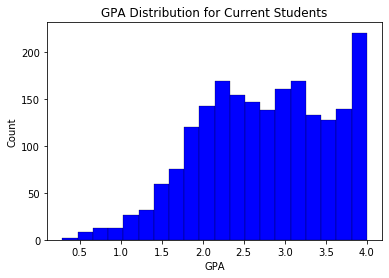

In [0]:
current_gpa_pdf = current_gpa.toPandas()

plt.hist(current_gpa_pdf.gpa, bins='auto',color='blue', linewidth=0.25, edgecolor='k')   #This graph has too many bins. The correct way to do this was to set bins = np.arange(0, 4.25, 0.25)
plt.title('GPA Distribution for Current Students')
plt.xlabel('GPA')
plt.ylabel('Count')
plt.show()

## Part I: Grade distribution by Instructor
In this part we will determine the distribution of the grades awarded by each faculty member

In [0]:
faculty_grade_dist = (
    grades
    .groupBy('fid')
    .agg(
        expr('COUNT(*) AS N'),
        expr('SUM(CASE WHEN grade == "A" THEN 1 ELSE 0 END) AS countA'),
        expr('SUM(CASE WHEN grade == "B" THEN 1 ELSE 0 END) AS countB'),
        expr('SUM(CASE WHEN grade == "C" THEN 1 ELSE 0 END) AS countC'),
        expr('SUM(CASE WHEN grade == "D" THEN 1 ELSE 0 END) AS countD'),
        expr('SUM(CASE WHEN grade == "F" THEN 1 ELSE 0 END) AS countF'),
    )
    .join(faculty, 'fid', 'inner')
    .select('fid', 'first_name', 'last_name', 'dept', 'N',
            expr('ROUND(countA / N,2) AS propA'),
            expr('ROUND(countB / N,2) AS propB'),
            expr('ROUND(countC / N,2) AS propC'),
            expr('ROUND(countD / N,2) AS propD'),
            expr('ROUND(countF / N,2) AS propF'),
           )
)

faculty_grade_dist.show(5)

+----+----------+---------+----+----+-----+-----+-----+-----+-----+
 fid|first_name|last_name|dept| N|propA|propB|propC|propD|propF|
+----+----------+---------+----+----+-----+-----+-----+-----+-----+
1088| Stephanie| Williams| MTH|1666| 0.17| 0.32| 0.36| 0.13| 0.01|
1829| Bobby| Wilson| GEN| 640| 0.13| 0.26| 0.37| 0.2| 0.04|
1238| Willie| Black| BIO| 682| 0.48| 0.33| 0.15| 0.04| 0.01|
2122| Jennifer| Porter| GEN| 825| 0.12| 0.29| 0.33| 0.21| 0.05|
1591| Amanda| Mitchell| CHM| 395| 0.09| 0.29| 0.35| 0.18| 0.08|
+----+----------+---------+----+----+-----+-----+-----+-----+-----+
only showing top 5 rows

We will now identify 10 faculty members who assign the fewest A grades

In [0]:
fewest_a = (
    faculty_grade_dist
    .filter(expr('N >= 100'))
    .sort('propA')
)

fewest_a.show(10)

+----+----------+---------+----+---+-----+-----+-----+-----+-----+
 fid|first_name|last_name|dept| N|propA|propB|propC|propD|propF|
+----+----------+---------+----+---+-----+-----+-----+-----+-----+
1628| Rebecca| Stewart| GEN|395| 0.03| 0.2| 0.37| 0.28| 0.12|
1481| Abigail| Brooks| BIO|311| 0.05| 0.23| 0.37| 0.28| 0.08|
3187| Joshua| Griffin| GEN|154| 0.05| 0.24| 0.38| 0.21| 0.12|
1264| Carol| Martin| CSC|302| 0.07| 0.22| 0.34| 0.25| 0.13|
1039| Joan| Lee| BIO|147| 0.07| 0.24| 0.31| 0.33| 0.05|
1479| Karen| Simmons| GEN|310| 0.08| 0.31| 0.3| 0.21| 0.1|
1212| Michael| Martinez| MTH|775| 0.09| 0.23| 0.31| 0.27| 0.11|
1591| Amanda| Mitchell| CHM|395| 0.09| 0.29| 0.35| 0.18| 0.08|
1462| Ralph| Perez| BIO|195| 0.09| 0.21| 0.39| 0.23| 0.09|
2925| Cynthia| Lewis| GEN|302| 0.09| 0.22| 0.35| 0.25| 0.09|
+----+----------+---------+----+---+-----+-----+-----+-----+-----+
only showing top 10 rows

Next we will identify the 10 faculty members who award the most A's

In [0]:
most_a = (
    faculty_grade_dist
    .filter(expr('N >= 100'))
    .sort('propA', ascending=False)
)

most_a.show(10)

+----+----------+---------+----+----+-----+-----+-----+-----+-----+
 fid|first_name|last_name|dept| N|propA|propB|propC|propD|propF|
+----+----------+---------+----+----+-----+-----+-----+-----+-----+
1092| Hannah| Morgan| GEN|1953| 0.59| 0.3| 0.09| 0.01| 0.0|
1262| Sara| Hunter| GEN|2266| 0.57| 0.28| 0.12| 0.02| 0.0|
1548| Donald| Gibson| GEN|1478| 0.55| 0.27| 0.14| 0.03| 0.01|
1094| Judy|Patterson| GEN|1904| 0.55| 0.32| 0.12| 0.02| 0.0|
1484| Billy| Cooper| BIO| 434| 0.54| 0.33| 0.09| 0.04| 0.01|
1328| David| Parker| GEN|1543| 0.53| 0.28| 0.14| 0.04| 0.01|
1058| John| Simpson| GEN|2729| 0.53| 0.33| 0.12| 0.02| 0.0|
1038| Theresa| Stevens| CHM| 233| 0.52| 0.31| 0.15| 0.02| 0.01|
1305| Betty| Stewart| GEN|2081| 0.51| 0.31| 0.14| 0.04| 0.01|
1291| Joyce| Butler| GEN|2212| 0.51| 0.31| 0.14| 0.03| 0.01|
+----+----------+---------+----+----+-----+-----+-----+-----+-----+
only showing top 10 rows

## Part J: First Term GPA
In this part, we will calculate the first-term GPA for each student

In [0]:
first_term_gpa = (
    grades
    .join(accepted, 'sid', 'left')
    .filter(expr('term_id == acc_term_id'))
    .join(courses, 'course', 'left')
    .withColumn('num_grade', expr('GPA(grade)'))
    .withColumn('gp', expr('credits * num_grade'))
    .groupBy('sid')
    .agg(
        expr('SUM(gp) AS N '),
        expr('SUM(credits) AS n_credits')
    )
    .select('sid', expr('ROUND(N / n_credits,2) AS first_term_gpa'))
)

first_term_gpa.show(5)

+------+--------------+
 sid|first_term_gpa|
+------+--------------+
100170| 2.0|
100446| 3.83|
100800| 0.39|
100884| 2.0|
100986| 0.33|
+------+--------------+
only showing top 5 rows

## Part K: Graduation Rates and First Term GPA
Lastly we will calcualte graduation rates for students whose first term GPA falls into four grade ranges `(0,1) (1,2) (2,3) (3,4)`

In [0]:
def gpa_bin(gpa):
    bins = ['[0,1)', '[1,2)', '[2,3)', '[3,4)']
    
    if gpa == 4.0:
        return bins[int(gpa)-1]
    
    return bins[int(gpa)]

spark.udf.register('GPA_BIN', gpa_bin)

Out[19]: <function __main__.gpa_bin(gpa)>

Next, we will calculate the number of alumni whose first-term GPA falls into each bin

In [0]:
alumni_ft_gpa = (
    first_term_gpa
    .join(alumni, 'sid', 'semi')
    .withColumn('gpa_bin', expr('GPA_BIN(first_term_gpa)'))
    .groupBy('gpa_bin')
    .agg(expr('COUNT(*) AS n_alumni'))
    .sort('gpa_bin')
)

alumni_ft_gpa.show()

+-------+--------+
gpa_bin|n_alumni|
+-------+--------+
 [0,1)| 4|
 [1,2)| 549|
 [2,3)| 1887|
 [3,4)| 2480|
+-------+--------+

Next, we will determine the number of former students whose first-term GPA falls into each bin

In [0]:
former_ft_gpa = (
    first_term_gpa
    .join(former, 'sid', 'semi')
    .withColumn('gpa_bin', expr('GPA_BIN(first_term_gpa)'))
    .groupBy('gpa_bin')
    .agg(expr('COUNT(*) AS n_former'))
    .sort('gpa_bin')
)

former_ft_gpa.show()

+-------+--------+
gpa_bin|n_former|
+-------+--------+
 [0,1)| 822|
 [1,2)| 1735|
 [2,3)| 2433|
 [3,4)| 2622|
+-------+--------+

We will now use the previous two dataframes to determine the graduation rate for each bin

In [0]:
(
    alumni_ft_gpa
    .join(former_ft_gpa, 'gpa_bin', 'inner')
    .withColumn('grad_rate', expr('ROUND(n_alumni / n_former,4)'))
    .sort('gpa_bin')
    .show()
)

+-------+--------+--------+---------+
gpa_bin|n_alumni|n_former|grad_rate|
+-------+--------+--------+---------+
 [0,1)| 4| 822| 0.0049|
 [1,2)| 549| 1735| 0.3164|
 [2,3)| 1887| 2433| 0.7756|
 [3,4)| 2480| 2622| 0.9458|
+-------+--------+--------+---------+